# Data

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

## 01 data loading

In [4]:
import os
import pandas as pd

In [5]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
y_path = os.path.join(base_path,os.getenv("Y_LABEL"))

In [6]:
gdp_df = pd.read_csv(y_path)

In [7]:
gdp_df

,年份,季別,GDP
0,1982,1,461774
1,1982,2,488234
2,1982,3,489504
3,1982,4,498511
4,1983,1,495361
...,...,...,...
163,2022,4,5896191
164,2023,1,5489013
165,2023,2,5710934
166,2023,3,6016101


In [8]:
gdp_df = gdp_df.drop(columns=['年份', '季別'])

In [9]:
len(gdp_df)

168

In [10]:
gdp_df = gdp_df.iloc[5:].reset_index(drop=True)

In [11]:
len(gdp_df)

163

In [12]:
gdp_df

,GDP
0,548158
1,554774
2,571153
3,562116
4,619704
...,...
158,5896191
159,5489013
160,5710934
161,6016101


## 02 data spliting 80 & 20

In [13]:
train_size = int(len(gdp_df) * 0.8)

In [14]:
train_df, test_df = gdp_df[:train_size], gdp_df[train_size:]

In [15]:
len(train_df)

130

In [18]:
train_df

,GDP
0,548158
1,554774
2,571153
3,562116
4,619704
...,...
125,4137478
126,4289807
127,4215980
128,4157711


In [16]:
len(test_df)

33

In [44]:
test_df

,GDP
130,4394740
131,4318253
132,4258596
133,4393874
134,4584545
135,4386857
136,4336020
137,4577156
138,4712354
139,4484529


# Model - ARIMA

In [35]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


- train 1983 Q2 to 2015 Q3 (130)
- test 2015 Q4 to 2023 Q4 (33)

In [36]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import numpy as np

from bayes_opt import BayesianOptimization

In [45]:
def eval_metrics(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} ➤ MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return mse, rmse, mae

In [58]:
auto_model = auto_arima(
    train_df['GDP'],
    seasonal=False,    # 因為通常GDP年資料不一定有季節性，若有季節性要 seasonal=True
    stepwise=True,     # 使用快速的stepwise方法
    trace=True         # 印出每一步測試的結果，幫助你觀察
)

print('自動選出的最適參數：', auto_model.order)  # 印出最好的 (p,d,q)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3231.660, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3313.179, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3314.368, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3310.480, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3323.915, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3296.682, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3288.883, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3228.167, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3257.617, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3223.174, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3239.549, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3223.630, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3222.797, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : 

In [59]:
best_order = auto_model.order
model = ARIMA(train_df['GDP'], order=best_order)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                  130
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -1617.541
Date:                Tue, 29 Apr 2025   AIC                           3251.082
Time:                        03:23:23   BIC                           3273.961
Sample:                             0   HQIC                          3260.378
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8137      0.155     -5.240      0.000      -1.118      -0.509
ar.L2         -0.9630      0.049    -19.613      0.000      -1.059      -0.867
ar.L3         -0.7807      0.148     -5.278      0.0

In [60]:
# 訓練集
train_pred = model_fit.predict(start=1, end=len(train_df), typ='levels')  # typ='levels'回到原始尺度

# 測試集
n_test = len(test_df)
test_pred = model_fit.forecast(steps=n_test)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [65]:
# 訓練集
print("\n📊 訓練集表現：")
eval_metrics(train_df,train_pred)

# 測試集
print("\n📊 測試集表現：")
eval_metrics(test_df,test_pred)



📊 訓練集表現：
 ➤ MSE: 3770760110.77, RMSE: 61406.52, MAE: 46112.28

📊 測試集表現：
 ➤ MSE: 908122384775.84, RMSE: 952954.56, MAE: 762817.50


(908122384775.8375, 952954.5554620312, 762817.4993358287)

In [112]:
import matplotlib.pyplot as plt

def plot_gdp_forecast(year,name,train_actual, train_pred, test_actual, test_pred):
    plt.figure(figsize=(12, 6))

    # 畫出四條線
    plt.plot(year.iloc[5:135],train_actual, label='Train Actual', color='blue', linestyle='-')
    plt.plot(year.iloc[5:135],train_pred, label='Train Predicted', color='cyan', linestyle='--')
    plt.plot(year.iloc[135:],test_actual, label='Test Actual', color='green', linestyle='-')
    plt.plot(year.iloc[135:],test_pred, label='Test Predicted', color='orange', linestyle='--')

    # 標題與座標軸
    plt.title(f'GDP Forecast with {name}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('GDP Value', fontsize=14)



    plt.xticks(year,rotation=45)
    
    # 顯示圖例
    plt.legend()

    # 顯示網格
    plt.grid(True, linestyle='--', alpha=0.7)

    # 顯示圖片
    plt.show()

In [113]:
y_df=pd.read_csv(y_path)

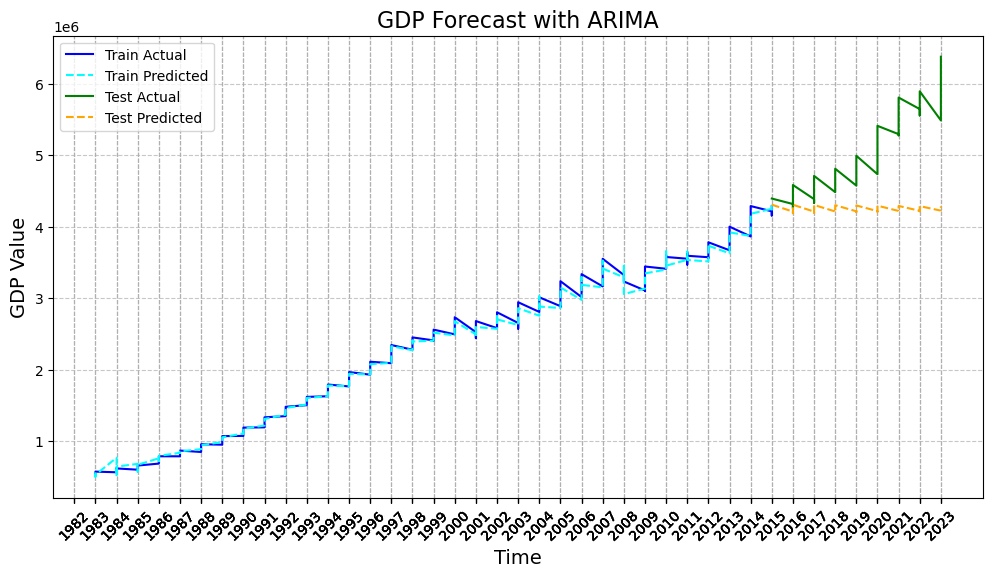

In [114]:
plot_gdp_forecast(y_df['年份'],'ARIMA',train_df,train_pred,test_df,test_pred)